# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam
import os

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
def energyStr (paramsE) :
    Efloat = float(paramsE)
    Eint = int(np.floor(Efloat))

    if Efloat - Eint == 0 :
        return "E" + str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return "E" + str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    # First term is the MSE, second term is used to constrain the probability to 1.
    return np.mean(diffeq**2) + (1 - prob)**2


iterList = []
diffeqList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    loss = mean + (1-prob)**2
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))
    
    print ("Iteration " + str(step) + " diffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))
    print ("---------------------------------")
    

# Callback function.
def callback(params, step, g):
    if step % 100 == 0:
        objectiveDebug (params, step)

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
x0 = 0  # Position of first boundary
x1 = 1  # Position of second boundary
L = 1 # Length of the well
n = 1 # Energy level to be found
scale = 2 # Scale for initialisation

# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# The ground state energy of the particle in a box is (pi^2)/2 = 4.9348. I've initialised E to 4.0
# so that it converges to the eigenenergy quickly.
params = {'nn': nnparams, 'E': 6.875}

# Input space
x = np.linspace(x0, x1, 200)[:, None]

# Setting up the name for saving files
name = "n" + str(n)+ "L" + str(L) + energyStr(params['E'])

# Optimization

In [5]:
params = adam(grad(objective), params,
              step_size=0.001, num_iters=10001, callback=callback) 

Iteration 0 diffeq = 1692.9696820762515 prob = 3.5325060280642115
loss = 1699.383268858433 E = 6.875
---------------------------------
Iteration 100 diffeq = 32.65823744726261 prob = 1.73508717299006
loss = 33.19859059915713 E = 6.818914111882063
---------------------------------
Iteration 200 diffeq = 7.70438755494689 prob = 1.0611174854303602
loss = 7.70812290197222 E = 6.731754138491775
---------------------------------
Iteration 300 diffeq = 3.9106340059587335 prob = 0.6911433523177545
loss = 4.006026434776248 E = 6.668555429906886
---------------------------------
Iteration 400 diffeq = 2.5229278878378385 prob = 0.4900779562781716
loss = 2.7829483785112847 E = 6.621255693335262
---------------------------------
Iteration 500 diffeq = 1.6259739650088239 prob = 0.3412078585629631
loss = 2.0599810506280205 E = 6.584277570098123
---------------------------------
Iteration 600 diffeq = 1.071736269322846 prob = 0.2412119429845524
loss = 1.6474955847921242 E = 6.555903725525642
---------

Iteration 5400 diffeq = 0.005277361781367101 prob = 1.1791770281884846e-05
loss = 1.0052537783798492 E = 6.446557207792017
---------------------------------
Iteration 5500 diffeq = 0.0049915159354543635 prob = 8.471790320902032e-06
loss = 1.0049745724265837 E = 6.446542988355855
---------------------------------
Iteration 5600 diffeq = 0.004726268126519418 prob = 5.877413015736117e-06
loss = 1.004714513335032 E = 6.446532724468681
---------------------------------
Iteration 5700 diffeq = 0.01266391771557913 prob = 3.0879754277036318e-06
loss = 1.0126577417742593 E = 6.446525996100537
---------------------------------
Iteration 5800 diffeq = 0.004283730139514536 prob = 2.4846098701772454e-06
loss = 1.0042787609259474 E = 6.446670768921609
---------------------------------
Iteration 5900 diffeq = 0.0040658727551593585 prob = 1.010339612744274e-06
loss = 1.0040638520769547 E = 6.446669213962666
---------------------------------
Iteration 6000 diffeq = 0.0038654917117791543 prob = 3.402277

# Plots

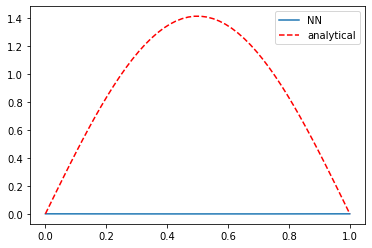

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig (name + "_plot.png")

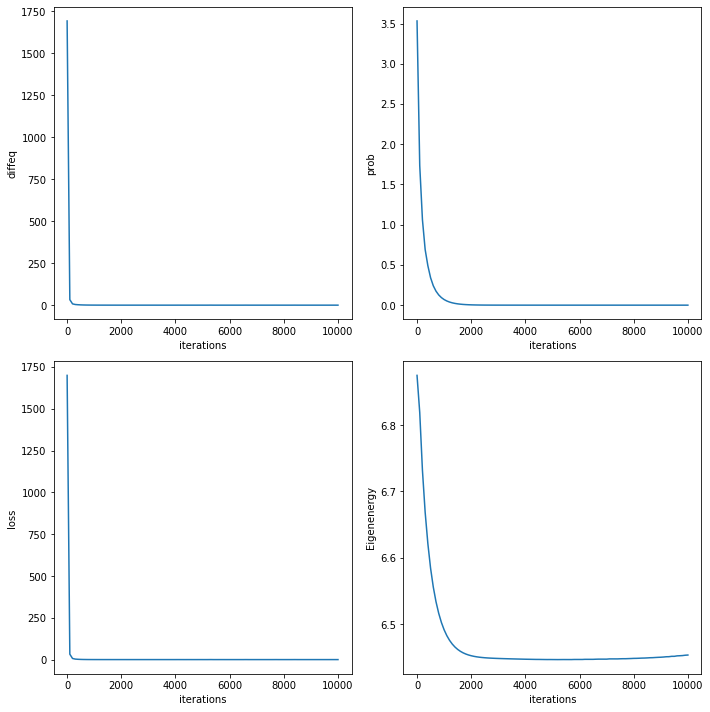

In [7]:
fig = plt.figure (figsize=(10,10))
plt.clf ()

plt.subplot (2 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagAll.png")

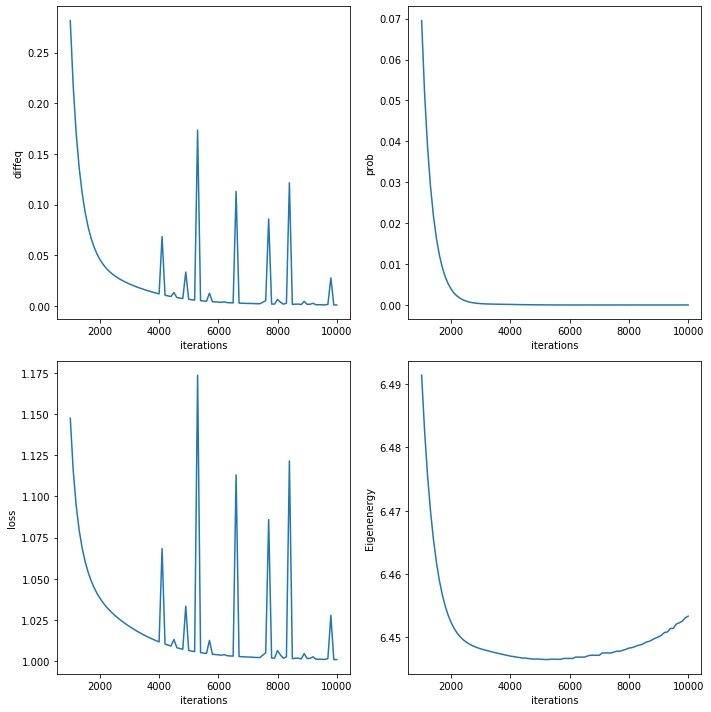

In [8]:
fig = plt.figure (figsize=(10,10))
trunc = 10

plt.subplot (2 , 2 , 1)
plt.plot (iterList[trunc:], diffeqList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList[trunc:], probList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList[trunc:], lossList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList[trunc:], EList[trunc:])
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

In [9]:
print ("\diffeq = " + str(round(diffeqList[-1],8)) + ", \prob = " + str(round(probList[-1],8)) + 
       ", \loss = " + str(round(lossList[-1],8)) + ", \eigE = " + str(round(EList[-1],8)))

\diffeq = 0.00101095, \prob = 3.2e-07, \loss = 1.0010103, \eigE = 6.45335208
